### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
from torch.optim import Adam

### A. Function to generate negative labels

In [ ]:
# Generates negative labels for the training data, which are required for contrastive divergence training

def get_y_neg(y):
  y_neg = y.clone()
  for idx, y_samp in enumerate(y):
    # create a list of all possible class labels
    allowed_indices = list(range(10))
    # remove the correct label from the list, leaving only incorrect labels
    allowed_indices.remove(y_samp.item())
    # assigning a random label from allowed_indices to y_neg[idx].
    y_neg[idx] = torch.tensor(allowed_indices)[torch.randint(len(allowed_indices), size=(1,))].item()

  # return the labels with incorrect class, moved to the specified device (CPU or GPU)
  return y_neg.to(device)

### B. Function to overlay label onto the input data

In [ ]:
# Overlays label info onto the input data, making a certain position in the tensor representative of the label

def overlay_y_on_x(x, y, classes=10):
  x_ = x.clone()
  # for all samples, set the first 10 column values to 0
  x_[:, :classes] *= 0.0
  # For each sample, set the feature at index corresponding to the class y to be the max value in x
  x_[range(x.shape[0]), y] = x.max()
  return x_

### C. Custom Net Class

In [ ]:
class Net(torch.nn.Module):
  def __init__(self, dims):
    # Initialize the parent class torch.nn.Module, Net is the subclass and torch.nn.Module is the parent class
    super().__init__()
    self.layers = []
    for d in range(len(dims) - 1):
      self.layers = self.layers + [Layer(dims[d], dims[d + 1]).to(device)]

  def predict(self, x):
    goodness_per_label = []

    # For each possible label (0 to 9)
    for label in range(10):
      # Apply the label overlay to the input to make h tensor (50000, 784) of same size as x
      h = overlay_y_on_x(x, label)
      # Create a list to store the goodness of each layer for this label
      goodness = []
      for layer in self.layers:
        # Apply the current layer to the transformed input tensor h, and then stores the result back into h.
        h = layer(h)
        # Add the squared mean (mean along each rows) of the output of this layer to the goodness list
        goodness = goodness + [h.pow(2).mean(1)]

      # Add the sum of the goodness of all layers for this label to the goodness_per_label list
      goodness_per_label += [sum(goodness).unsqueeze(1)]

    # Concatenate all the goodness_per_label tensors along dimension 1
    goodness_per_label = torch.cat(goodness_per_label, 1)
    return goodness_per_label.argmax(1)

  def train(self, x_pos, x_neg):
    h_pos, h_neg = x_pos, x_neg
    for i, layer in enumerate(self.layers):
      h_pos, h_neg = layer.train(h_pos, h_neg)

### D. Custom Layer Class

In [ ]:
class Layer(nn.Linear):
  def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
    super().__init__(in_features, out_features, bias, device, dtype)
    self.relu = torch.nn.ReLU()
    self.opt = Adam(self.parameters(), lr=args.lr)
    self.threshold = args.threshold
    self.num_epochs = args.epochs


  def forward(self, x):
    x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
    return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

  def train(self, x_pos, x_neg):
    loss_values = []
    g_pos_values = []
    g_neg_values = []
    for i in range(self.num_epochs):
      g_pos = self.forward(x_pos).pow(2).mean(1)
      g_neg = self.forward(x_neg).pow(2).mean(1)
      loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
      self.opt.zero_grad()
      loss.backward()
      self.opt.step()
      if i % args.log_interval == 0:
        loss_values.append(loss.item())
        g_pos_values.append(g_pos.mean().item())  # take mean of all batch values
        g_neg_values.append(g_neg.mean().item())  # take mean of all batch values


      print(f'Loss at step {i}: {loss.item()}')
    return self.forward(x_pos).detach(), self.forward(x_neg).detach()

### E. Network Hyperparameters and device setup

In [ ]:
class Args:
  train_size = 50000
  test_size = 10000
  epochs = 10
  lr = 0.05
  no_cuda = False
  no_mps = False
  save_model = False
  threshold = 0
  seed = 1234
  log_interval = 10

args = Args()

use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {"batch_size": args.train_size}
test_kwargs = {"batch_size": args.test_size}

# If CUDA is available
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

# 1. Load data

In [ ]:
transform = Compose([ToTensor(),Normalize((0.1307,), (0.3081,)), Lambda(lambda x: torch.flatten(x)),])

train_loader = DataLoader(MNIST("./data/", train=True, download=True, transform=transform), **train_kwargs)
test_loader = DataLoader(MNIST("./data/", train=False, download=True, transform=transform), **test_kwargs)

# 2. Create network

In [ ]:
# Create an instance of Net class with an input dim of 784 neurons to match the flattened 28x28 pixel MNIST images
net =  Net([784, 400, 400, 400])

# 3. Generate negetive samples and Train the network

In [ ]:
# x is a 2D tensor of size (batch_size, 784) and y is a 1D tensor of size (batch_size,).
x, y = next(iter(train_loader))

# Move the input data and labels to the specified device (CPU or GPU).
x, y = x.to(device), y.to(device)

# overlay_y_on_x() function returns a 2D tensor of size (batch_size, 784)
x_pos = overlay_y_on_x(x, y)

# get_y_neg() function returns a 1D tensor of size (batch_size,) with the negative labels.
y_neg = get_y_neg(y)

# overlay_y_on_x() function returns a 2D tensor of size (batch_size, 784)
x_neg = overlay_y_on_x(x, y_neg)

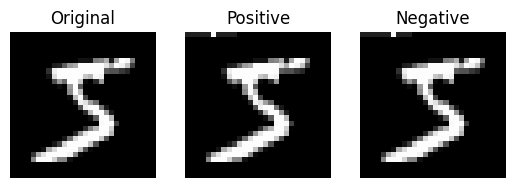

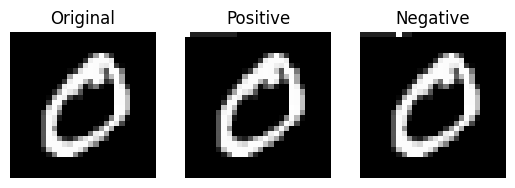

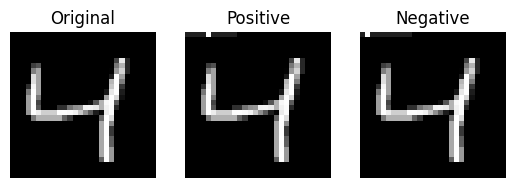

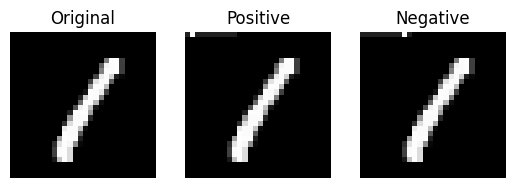

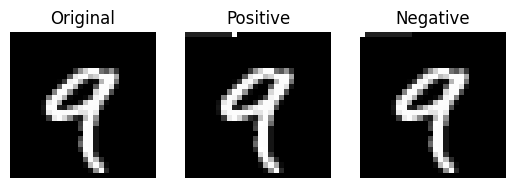

In [ ]:
x_np = x.cpu().numpy()
x_pos_np = x_pos.cpu().numpy()
x_neg_np = x_neg.cpu().numpy()


x_np = x_np.reshape(-1, 28, 28)
x_pos_np = x_pos_np.reshape(-1, 28, 28)
x_neg_np = x_neg_np.reshape(-1, 28, 28)

# Plot 5 samples
for i in range(5):
  fig, axs = plt.subplots(1, 3)

  # Original images
  axs[0].imshow(x_np[i], cmap='gray')
  axs[0].set_title('Original')
  axs[0].axis('off')

  # Positive images
  axs[1].imshow(x_pos_np[i], cmap='gray')
  axs[1].set_title('Positive')
  axs[1].axis('off')

  # Negative images
  axs[2].imshow(x_neg_np[i], cmap='gray')
  axs[2].set_title('Negative')
  axs[2].axis('off')

In [ ]:
# Train the network with the positive and negative examples.
net.train(x_pos, x_neg)

Loss at step 0: 0.6931471824645996
Loss at step 1: 0.6931152939796448
Loss at step 2: 0.6930667161941528
Loss at step 3: 0.6929317116737366
Loss at step 4: 0.6927429437637329
Loss at step 5: 0.6925420165061951
Loss at step 6: 0.6922963857650757
Loss at step 7: 0.6920249462127686
Loss at step 8: 0.6916893720626831
Loss at step 9: 0.6913615465164185
Loss at step 0: 0.6931474804878235
Loss at step 1: 0.6930813193321228
Loss at step 2: 0.6929175853729248
Loss at step 3: 0.692694365978241
Loss at step 4: 0.6924377083778381
Loss at step 5: 0.6921661496162415
Loss at step 6: 0.6918807625770569
Loss at step 7: 0.6915806531906128
Loss at step 8: 0.691270649433136
Loss at step 9: 0.6909492015838623
Loss at step 0: 0.6931468844413757
Loss at step 1: 0.6930415034294128
Loss at step 2: 0.6930021643638611
Loss at step 3: 0.693027675151825
Loss at step 4: 0.6929498314857483
Loss at step 5: 0.6929194331169128
Loss at step 6: 0.6928884387016296
Loss at step 7: 0.6928233504295349
Loss at step 8: 0.69276

In [ ]:
# Predict the labels for the training data, compare them to the actual labels, and calculate the error rate.
print("Train Accuracy: {:.2f}%".format(100 * net.predict(x).eq(y).float().mean().item()))

Train Accuracy: 75.78%


# 4. Test the Network

In [ ]:
# Fetch one batch of the test data.
x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.to(device), y_te.to(device)
if args.save_model:
    torch.save(net.state_dict(), "mnist_ff.pt")

# Predict the labels for the test data, compare them to the actual labels, and calculate the error rate.
print("Test Accuracy: {:.2f}%".format(100 * net.predict(x_te).eq(y_te).float().mean().item()))

Test Accuracy: 76.58%


# Questions

### c) The positive pass is used on real data and tweaks the weights to increase the ‘goodness’ in the hidden layer. The negative pass operates on ‘negative data’ and tweaks the weights to decrease the goodness of the hidden layer.
The following definition is a good one for loss,

loss = mean(log(1 + e^[(threshold−positivedata),(negativedata−threshold)]))

since (1) it's nonnegetive function so loss is always greater than zero (2) by increasing negetivedata, negetivedata-thre increases and the corresponding exponential becomes greater than one. In the same way by decreasing positivedata, thre-positivedata increases and the corresponding exponential becomes greater than one. Since we want to increase positivedata and decrease negetivedata, this definition of loss works for us.
